<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/CODE4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
chsum = 0
##pbar = tqdm(train_loader_nonorm)

for index, (data,target) in enumerate(train_loader_nonorm):
    chsum += data.sum(dim=(0,2,3),keepdim=True)

mean = chsum / (len(train_nonorm) * 32 *32)
#
chsum = None
for index, (data,target) in enumerate(train_loader_nonorm):
  if index == 0:
   print(data.min(),data.max())
   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
  else:
   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
print("Traindata Mean",mean)
print("Traindata std dev",std)

chsum = 0

for index, (data,target) in enumerate(test_loader_nonorm):
    chsum += data.sum(dim=(0,2,3),keepdim=True)

mean = chsum / (len(test_nonorm) * 32 *32)

chsum = None
for index, (data,target) in enumerate(test_loader_nonorm):
  if index == 0:
    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
  else:
   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
print("Test data Mean",mean)
print("Test data std dev",std)

ship


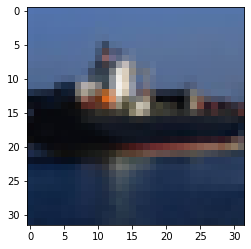

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [12]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32 ; #Receptive field = 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 5x5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 7x7

        self.convblock16 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups=64, kernel_size=(3, 3), padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 7x7


        #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32; #Receptive field = 7x7

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, dilation =2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling
        #self.pool1 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #   nn.Dropout(dropout_perc)
        #    #nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        #)
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, dilation = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        #BLOCK C3
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #BLOCK C4
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64 , kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=128, groups = 128, out_channels=256, kernel_size=(3, 3), padding=0, bias=False)
            #n.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(256,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock16(x)
        x = self.convblock4(x)
        
        x = self.pool1(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.pool2(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [13]:
#model = BatchNormNet().to(device)
#summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           1,152
      BatchNorm2d-14          [-1, 128,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [14]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [15]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           1,152
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/391 [00:00<?, ?it/s]

           Conv2d-17           [-1, 32, 32, 32]           4,096
           Conv2d-18           [-1, 64, 16, 16]          18,432
      BatchNorm2d-19           [-1, 64, 16, 16]             128
             ReLU-20           [-1, 64, 16, 16]               0
          Dropout-21           [-1, 64, 16, 16]               0
           Conv2d-22          [-1, 128, 16, 16]           1,152
      BatchNorm2d-23          [-1, 128, 16, 16]             256
             ReLU-24          [-1, 128, 16, 16]               0
          Dropout-25          [-1, 128, 16, 16]               0
           Conv2d-26          [-1, 256, 16, 16]           2,304
      BatchNorm2d-27          [-1, 256, 16, 16]             512
             ReLU-28          [-1, 256, 16, 16]               0
          Dropout-29          [-1, 256, 16, 16]               0
           Conv2d-30           [-1, 32, 16, 16]           8,192
           Conv2d-31             [-1, 64, 8, 8]          18,432
      BatchNorm2d-32             [-1, 64

Loss=2.0886988639831543 Batch_id=390 Accuracy=35.60: 100%|██████████| 391/391 [00:23<00:00, 16.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 13895.2242, Accuracy: 4905/10000 (49.05%)

EPOCH: 1


Loss=1.9599742889404297 Batch_id=390 Accuracy=50.97: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10317.6554, Accuracy: 6309/10000 (63.09%)

EPOCH: 2


Loss=1.4900805950164795 Batch_id=390 Accuracy=56.49: 100%|██████████| 391/391 [00:23<00:00, 16.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9863.4533, Accuracy: 6492/10000 (64.92%)

EPOCH: 3


Loss=1.7694737911224365 Batch_id=390 Accuracy=59.62: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9035.3581, Accuracy: 6893/10000 (68.93%)

EPOCH: 4


Loss=1.8115859031677246 Batch_id=390 Accuracy=61.74: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8569.1879, Accuracy: 7008/10000 (70.08%)

EPOCH: 5


Loss=1.5387712717056274 Batch_id=390 Accuracy=63.06: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7749.6241, Accuracy: 7339/10000 (73.39%)

EPOCH: 6


Loss=1.4762639999389648 Batch_id=390 Accuracy=64.39: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7233.2038, Accuracy: 7509/10000 (75.09%)

EPOCH: 7


Loss=1.3717215061187744 Batch_id=390 Accuracy=65.38: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7414.7794, Accuracy: 7436/10000 (74.36%)

EPOCH: 8


Loss=1.4994192123413086 Batch_id=390 Accuracy=66.35: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8511.8492, Accuracy: 7007/10000 (70.07%)

EPOCH: 9


Loss=1.5633864402770996 Batch_id=390 Accuracy=66.92: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7150.2601, Accuracy: 7574/10000 (75.74%)

EPOCH: 10


Loss=1.461529016494751 Batch_id=390 Accuracy=67.64: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7636.4596, Accuracy: 7409/10000 (74.09%)

EPOCH: 11


Loss=1.4290775060653687 Batch_id=390 Accuracy=67.85: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7494.8825, Accuracy: 7418/10000 (74.18%)

EPOCH: 12


Loss=1.6260803937911987 Batch_id=390 Accuracy=68.44: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6583.5826, Accuracy: 7721/10000 (77.21%)

EPOCH: 13


Loss=1.430668592453003 Batch_id=390 Accuracy=68.60: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6506.9551, Accuracy: 7735/10000 (77.35%)

EPOCH: 14


Loss=1.5865927934646606 Batch_id=390 Accuracy=69.14: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6264.6592, Accuracy: 7856/10000 (78.56%)

EPOCH: 15


Loss=1.3665568828582764 Batch_id=390 Accuracy=69.56: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6118.6595, Accuracy: 7883/10000 (78.83%)

EPOCH: 16


Loss=1.299597978591919 Batch_id=390 Accuracy=70.21: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6146.7526, Accuracy: 7867/10000 (78.67%)

EPOCH: 17


Loss=1.5224518775939941 Batch_id=390 Accuracy=70.17: 100%|██████████| 391/391 [00:24<00:00, 16.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6690.9980, Accuracy: 7672/10000 (76.72%)

EPOCH: 18


Loss=1.2603230476379395 Batch_id=390 Accuracy=70.67: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6549.7523, Accuracy: 7703/10000 (77.03%)

EPOCH: 19


Loss=1.4908092021942139 Batch_id=390 Accuracy=70.79: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6150.7984, Accuracy: 7900/10000 (79.00%)

EPOCH: 20


Loss=1.2544820308685303 Batch_id=390 Accuracy=71.16: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6164.8231, Accuracy: 7883/10000 (78.83%)

EPOCH: 21


Loss=1.2359192371368408 Batch_id=390 Accuracy=71.73: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6107.5962, Accuracy: 7943/10000 (79.43%)

EPOCH: 22


Loss=1.36382257938385 Batch_id=390 Accuracy=71.37: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6005.9071, Accuracy: 7956/10000 (79.56%)

EPOCH: 23


Loss=1.17310631275177 Batch_id=390 Accuracy=71.58: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5706.6996, Accuracy: 8042/10000 (80.42%)

EPOCH: 24


Loss=1.1623246669769287 Batch_id=390 Accuracy=71.70: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5662.5246, Accuracy: 8036/10000 (80.36%)

EPOCH: 25


Loss=1.2429091930389404 Batch_id=390 Accuracy=71.87: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6632.5152, Accuracy: 7777/10000 (77.77%)

EPOCH: 26


Loss=1.1936006546020508 Batch_id=390 Accuracy=72.27: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6062.0209, Accuracy: 7911/10000 (79.11%)

EPOCH: 27


Loss=1.4788070917129517 Batch_id=390 Accuracy=72.43: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5713.9403, Accuracy: 8027/10000 (80.27%)

EPOCH: 28


Loss=1.3912994861602783 Batch_id=390 Accuracy=72.31: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5901.4723, Accuracy: 7978/10000 (79.78%)

EPOCH: 29


Loss=1.3072965145111084 Batch_id=390 Accuracy=72.59: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5727.0988, Accuracy: 8007/10000 (80.07%)

EPOCH: 30


Loss=1.5635019540786743 Batch_id=390 Accuracy=72.79: 100%|██████████| 391/391 [00:24<00:00, 16.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5430.1812, Accuracy: 8106/10000 (81.06%)

EPOCH: 31


Loss=1.2183853387832642 Batch_id=390 Accuracy=73.04: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5519.4139, Accuracy: 8106/10000 (81.06%)

EPOCH: 32


Loss=1.1133625507354736 Batch_id=390 Accuracy=72.77: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4997.3582, Accuracy: 8297/10000 (82.97%)

EPOCH: 33


Loss=1.4292291402816772 Batch_id=390 Accuracy=73.08: 100%|██████████| 391/391 [00:24<00:00, 16.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5367.9773, Accuracy: 8173/10000 (81.73%)

EPOCH: 34


Loss=1.3275009393692017 Batch_id=390 Accuracy=73.20: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5722.2094, Accuracy: 8078/10000 (80.78%)

EPOCH: 35


Loss=1.1801621913909912 Batch_id=390 Accuracy=73.12: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5277.7414, Accuracy: 8165/10000 (81.65%)

EPOCH: 36


Loss=1.3475676774978638 Batch_id=390 Accuracy=73.17: 100%|██████████| 391/391 [00:24<00:00, 16.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5305.1839, Accuracy: 8200/10000 (82.00%)

EPOCH: 37


Loss=1.2044901847839355 Batch_id=390 Accuracy=73.60: 100%|██████████| 391/391 [00:23<00:00, 16.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5380.9854, Accuracy: 8179/10000 (81.79%)

EPOCH: 38


Loss=1.1268664598464966 Batch_id=390 Accuracy=73.48: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5515.1287, Accuracy: 8120/10000 (81.20%)

EPOCH: 39


Loss=1.1704185009002686 Batch_id=390 Accuracy=73.70: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5055.1066, Accuracy: 8306/10000 (83.06%)

EPOCH: 40


Loss=1.0548303127288818 Batch_id=390 Accuracy=73.77: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5127.6270, Accuracy: 8228/10000 (82.28%)

EPOCH: 41


Loss=1.212864875793457 Batch_id=390 Accuracy=73.88: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5348.1671, Accuracy: 8201/10000 (82.01%)

EPOCH: 42


Loss=1.155515432357788 Batch_id=390 Accuracy=73.97: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5173.0710, Accuracy: 8243/10000 (82.43%)

EPOCH: 43


Loss=1.3368653059005737 Batch_id=390 Accuracy=74.05: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5351.3778, Accuracy: 8142/10000 (81.42%)

EPOCH: 44


Loss=1.2269365787506104 Batch_id=390 Accuracy=74.31: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5418.8286, Accuracy: 8147/10000 (81.47%)

EPOCH: 45


Loss=1.1318604946136475 Batch_id=390 Accuracy=74.08: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5402.9622, Accuracy: 8152/10000 (81.52%)

EPOCH: 46


Loss=1.2608411312103271 Batch_id=390 Accuracy=74.42: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5033.9924, Accuracy: 8264/10000 (82.64%)

EPOCH: 47


Loss=1.1600308418273926 Batch_id=390 Accuracy=74.27: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5239.0004, Accuracy: 8205/10000 (82.05%)

EPOCH: 48


Loss=1.2002676725387573 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5338.4840, Accuracy: 8141/10000 (81.41%)

EPOCH: 49


Loss=1.0333442687988281 Batch_id=390 Accuracy=74.52: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5115.6935, Accuracy: 8264/10000 (82.64%)

EPOCH: 50


Loss=0.9888163805007935 Batch_id=390 Accuracy=74.37: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4994.5533, Accuracy: 8243/10000 (82.43%)

EPOCH: 51


Loss=1.002931833267212 Batch_id=390 Accuracy=74.81: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5009.3073, Accuracy: 8233/10000 (82.33%)

EPOCH: 52


Loss=1.067493200302124 Batch_id=390 Accuracy=74.59: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5081.1613, Accuracy: 8215/10000 (82.15%)

EPOCH: 53


Loss=1.0075263977050781 Batch_id=390 Accuracy=74.82: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5356.1657, Accuracy: 8157/10000 (81.57%)

EPOCH: 54


Loss=1.109580159187317 Batch_id=390 Accuracy=75.06: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5002.9946, Accuracy: 8261/10000 (82.61%)

EPOCH: 55


Loss=1.1722346544265747 Batch_id=390 Accuracy=74.69: 100%|██████████| 391/391 [00:24<00:00, 16.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4825.5538, Accuracy: 8380/10000 (83.80%)

EPOCH: 56


Loss=1.0871965885162354 Batch_id=390 Accuracy=75.04: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4910.9203, Accuracy: 8307/10000 (83.07%)

EPOCH: 57


Loss=1.2461153268814087 Batch_id=390 Accuracy=74.90: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5732.6454, Accuracy: 8071/10000 (80.71%)

EPOCH: 58


Loss=1.1085286140441895 Batch_id=390 Accuracy=74.74: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5169.5063, Accuracy: 8222/10000 (82.22%)

EPOCH: 59


Loss=1.0175461769104004 Batch_id=390 Accuracy=75.17: 100%|██████████| 391/391 [00:24<00:00, 16.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 5032.2388, Accuracy: 8237/10000 (82.37%)

Actual Labels
  car   cat   car   car plane  bird  ship   cat  bird  bird
Predicted Labels
truck truck truck truck truck truck truck   dog  deer plane


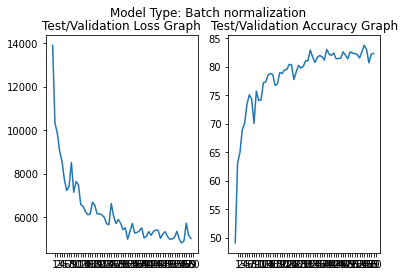

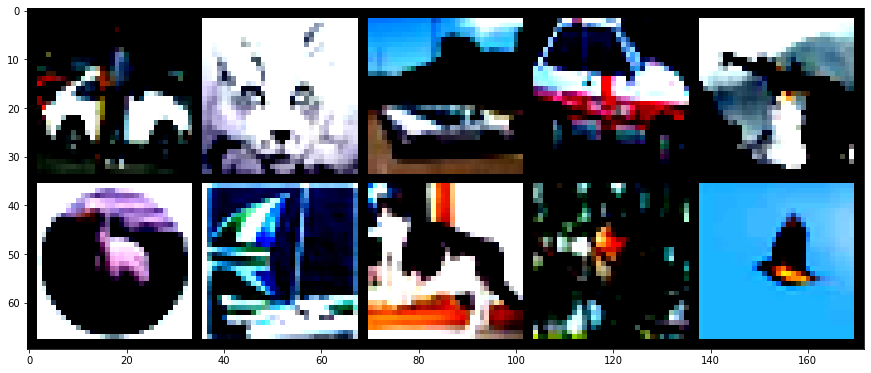

In [16]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,60)


In [17]:
#

#test_10_images = torch.stack(test_10_images)
#print(test_10_images.dtype)
##print(test_10_images)
#grid = torchvision.utils.make_grid(torch.stack(test_fail_data), nrow=5)
#plt.figure(figsize=(15,15))
#plt.imshow(np.transpose(grid, (1,2,0)))